# Download Dataset

In [1]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d shivamb/netflix-shows
!unzip netflix-shows.zip

 75% 1.00M/1.34M [00:00<00:00, 1.14MB/s]
100% 1.34M/1.34M [00:00<00:00, 1.43MB/s]
Archive:  netflix-shows.zip
  inflating: netflix_titles.csv      


# Import Required Library

In [3]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Data Understanding
Dataset berisi daftar film dan rinciannya seperti tahun dirilis, waktu durasi, deskripsi dll.

In [26]:
data = pd.read_csv('netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Dari table diatas berikut penjelasan masing-masing fitur pada data:
*   title, merupakan judul film.
*   show_id, berisi id penayangan.
*   type, merupakan jenis film (Movie/Tv Show).
*   director, berisi nama penanggungjawab program/film.
*   cast, daftar pemeran yang bermain dalam film.
*   country, daerah asal film diproduksi.
*   date_added, tanggal film di masukkan ke dalam dataset.
*   release_year, tahun film rilis.
*   rating, kategori rating usia yang diperbolehkan menonton film tersebut.
*   duration, durasi waktu film dari awal hingga selesai.
*   listed_in, berisi kategori film.
*   description, merupakan deskripsi atau sinopsis film.

In [5]:
# Mengecek jumlah baris dan kolom dataset
data.shape

(8807, 12)

Dataset ini memiliki 8870 baris dan 12 kolom

In [6]:
# Cek daftar type film
data.type.unique()

array(['Movie', 'TV Show'], dtype=object)


### Melihat Distribusi Rating

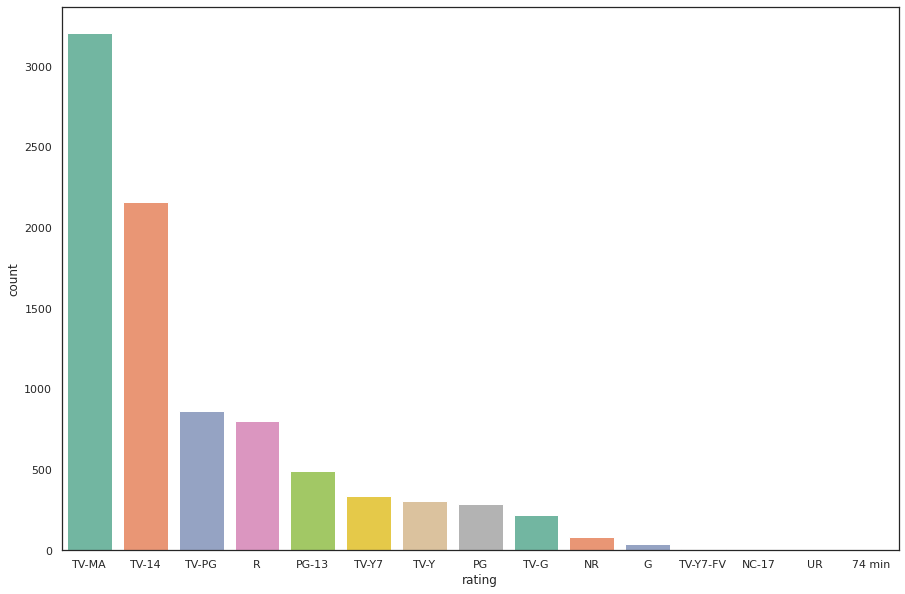

In [7]:
plt.figure(figsize=(15,10))
sns.set(style="white")
ax = sns.countplot(x="rating", data=data, palette="Set2", order=data['rating'].value_counts().index[0:15])

Dengan countplot rating ini dapat diketahui bahwa konten TV-MA (Mature Audiences) memiliki angka rating tertinggi. Kemudian menjadi lebih rendah seperti TV-14 (Materi yang mungkin dianggap tidak cocok oleh orang tua atau wali dewasa untuk anak di bawah usia 14 tahun) dan TV-PG (Panduan Orang Tua

### Melihat Distribusi Tahun Rilis

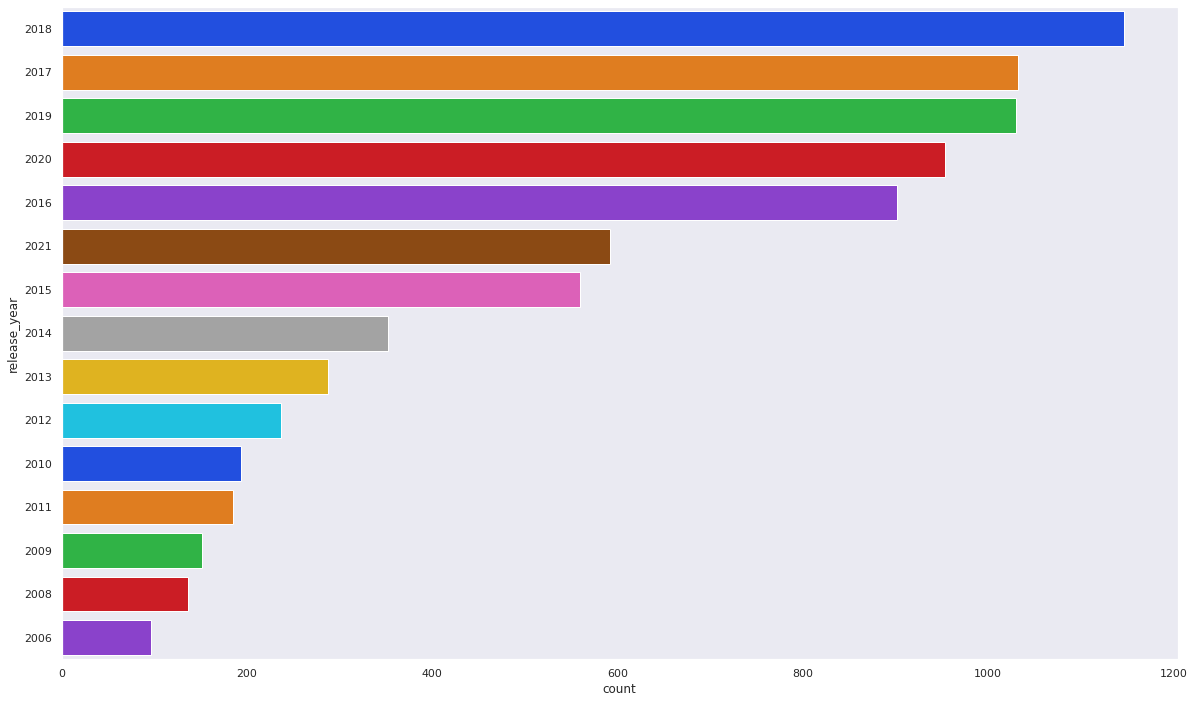

In [8]:
plt.figure(figsize=(20,12))
sns.set(style="dark")
ax = sns.countplot(y="release_year", data=data, palette="bright", order=data['release_year'].value_counts().index[0:15])

Plot ini menunjukkan bahwa sebagian besar konten diproduksi pada tahun 2018 dan 2017. Fakta yang menarik adalah pada tahun 2019, 2020 dan 2021 jumlah konten yang diproduksi sedikit. Ini sebagian besar karena pandemi Covid-19

# Data Preparation

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [27]:
# Cek missing value
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Dari hasil pengecekan terdapat banyak missing value pada dataset kolom director, cast, country, date_added, rating, dan duration

Pada proses pembuatan sistem rekomendasi yang diperlukan hanyalah kolom judul dan rating sehingga kita bisa membuat data baru yang berisi kolom rating dan judul film saja.

In [40]:
# Drop Columns 
df = data[['title','rating']]

# Drop the rest
df.dropna(inplace=True)

# Cek missing value
df.isnull().sum()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


title     0
rating    0
dtype: int64

Hasil diatas menunjukkan data sudah tidak memiliki missing value/null

In [41]:
df.rating.unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR',
       'TV-Y7-FV', 'UR'], dtype=object)

pada kolom rating terdapat beberapa kategori yang cukup aneh yaitu '74 min', '84 min', '66 min', karena itu mari kita lihat film apa saja yang termasuk kategori rating tersebut

In [42]:
data[data.rating.apply(lambda x: x in ['74 min', '84 min', '66 min'])]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


Dari hasil pengecekan hanya terdapat 3 baris data untuk kategori rating '74 min', '84 min', '66 min'. Mengacu pada laman netflix, film dengan judul Louis C.K. memiliki maturity rating TV-MA. Sehingga kita bisa melakukan replace dengan rating tersebut

In [48]:
df['rating'] = df.rating.apply(lambda x: 'TV-MA' if x in ['74 min', '84 min', '66 min'] else x)
df.rating.unique()

<ipython-input-48-3b11665e1627>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df.rating.apply(lambda x: 'TV-MA' if x in ['74 min', '84 min', '66 min'] else x)


array(['Teens', 'Adults', 'Older Kids', 'Kids', 'TV-MA'], dtype=object)

Sekarang seluruh data rating telah memiliki kategori yang sesuai. Selanjutnya untuk mempermudah kita akan mengelompokkan beberapa kategori rating maturity menjadi 4 kategori saja yakni  ‘Adults’, ‘Teens’, ‘Older Kids’, ‘Kids’

In [49]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'PG': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
# Replace Rating values with age targets, they are based on
df['rating'] = df['rating'].replace(ratings_ages)
df.rating.unique()

<ipython-input-49-c0fd3b22ee3e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].replace(ratings_ages)


array(['Teens', 'Adults', 'Older Kids', 'Kids'], dtype=object)

# Model Development

In [50]:
df.sample(5)

,title,rating
7550,My Wife and My Wifey,Teens
2845,The Death of Mr. Lazarescu,Adults
5711,Carlos Ballarta: El amor es de putos,Adults
8217,The Book of Eli,Adults
6408,Camelia la Texana,Teens


In [51]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer(stop_words='english')
 
# Melakukan perhitungan idf pada data rating
tf.fit(df.rating) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['adults', 'kids', 'older', 'teens']

In [52]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df.rating) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(8803, 4)

Hasil transformasi menghasilkan matriks berukuran (8803, 4). Nilai 8803 merupakan ukuran data dan 4 merupakan matriks naturity rating film.

In [53]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        ...,
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.66219617, 0.74933052, 0.        ],
        [0.        , 0.        , 0.        , 1.        ]])

In [54]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan kategori maturity rating
# Baris diisi dengan judul film
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=df.title
).sample(4, axis=1).sample(10, axis=0)

,teens,kids,older,adults
title,,,,
The Lamb,0.0,0.662196,0.749331,0.0
FirstBorn,0.0,0.000000,0.000000,1.0
Q Ball,0.0,0.000000,0.000000,1.0
City of Joy,0.0,0.000000,0.000000,1.0
Richie Rich,0.0,1.000000,0.000000,0.0
The Forest of Love,0.0,0.000000,0.000000,1.0
Masha's Spooky Stories,0.0,1.000000,0.000000,0.0
Okupas,0.0,0.000000,0.000000,1.0
NOVA: Black Hole Apocalypse,0.0,1.000000,0.000000,0.0


Data diatas menunjukkan film **FirstBorn** memiliki rating adults, film **Okupas** memiliki raitng adult, dan seterusnya

### Cosine Similarity

In [59]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [56]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=df.title, columns=df.title)
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (8803, 8803)


title,Stargate,The Occupant,Phullu,Dragonheart: Vengeance,Clarence Clemons: Who Do I Think I Am?
title,,,,,
My Husband Won't Fit,0.0,1.0,0.0,0.0,1.0
The Open House,0.0,1.0,0.0,0.0,1.0
Momo Salon,1.0,0.0,1.0,1.0,0.0
Confessions of an Invisible Girl,0.0,0.0,0.0,0.0,0.0
Marriage or Mortgage,0.0,0.0,0.0,0.0,0.0
Defiance,0.0,1.0,0.0,0.0,1.0
The Mad Monk,1.0,0.0,1.0,1.0,0.0
Blind Intersections,0.0,1.0,0.0,0.0,1.0
Una,0.0,1.0,0.0,0.0,1.0


Output tabel diatas menunjukkan bahwa film **The Open House** memiliki kemiripan dengan film **The Occupant** , film **Momo Salon** memiliki kemiripan dengan film **Phullu**, dan seterusnya

### Mendapatkan Rekomendasi

In [60]:
def film_recommendations(nama_film, similarity_data=cosine_sim_df, items=df[['title', 'rating']], k=10):
    """
    Rekomendasi film berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    nama_film : tipe data string (str)
                Nama filmran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan film sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_film].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_film agar nama film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_film, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [57]:
df.sample()

,title,rating
6388,Bullitt County,Adults


In [71]:
recommendation = film_recommendations("Bullitt County")
recommendation

,title,rating
0,Chelsea Handler: Uganda Be Kidding Me Live,Adults
1,We Are the Champions,Adults
2,The Perfect Dictatorship,Adults
3,Hot Girls Wanted,Adults
4,Jen Kirkman: I'm Gonna Die Alone (And I Feel F...,Adults
5,Chris D'Elia: Incorrigible,Adults
6,Advantageous,Adults
7,Lilyhammer,Adults
8,My Own Man,Adults
9,Kevin Hart: Zero F**ks Given,Adults


### Evaluation

In [81]:
precission = recommendation[recommendation.rating.eq("Adults")].shape[0]//recommendation.shape[0]
print(f"[+] Precission: {precission*100}%")

[+] Precission: 100%
